# Alphalens 分析

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## 加载数据

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## 线性回归

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001836
                           AAPL     -0.001626
                           ABBV      0.001321
                           AGN       0.002162
                           AIG      -0.000331
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 257 entries, AAL to GWW
dtypes: float64(257)
memory usage: 2.0 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.047411,0.008700,-0.003169,0.004062,14982,20.231183
2,-0.015560,0.010750,-0.000996,0.003360,14877,20.089394
3,-0.013523,0.012632,0.000134,0.003351,14336,19.358846
4,-0.012081,0.014850,0.001213,0.003458,14877,20.089394
5,-0.010094,0.038492,0.003323,0.004279,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.021,0.010,0.007
beta,-0.010,-0.079,-0.060,0.012
Mean Period Wise Return Top Quantile (bps),1.108,0.724,0.028,0.212
Mean Period Wise Return Bottom Quantile (bps),-2.869,-0.714,-0.524,-0.740
Mean Period Wise Spread (bps),3.976,1.468,0.575,0.944


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.013,0.013,0.014
IC Std.,0.181,0.167,0.167,0.155
Risk-Adjusted IC,0.108,0.079,0.077,0.093
t-stat(IC),2.965,2.168,2.105,2.555
p-value(IC),0.003,0.030,0.036,0.011
IC Skew,0.005,-0.018,-0.031,-0.022
IC Kurtosis,-0.129,-0.178,-0.153,-0.291


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.296,0.520,0.621,0.728
Quantile 2 Mean Turnover,0.516,0.710,0.757,0.791
Quantile 3 Mean Turnover,0.568,0.739,0.777,0.804
Quantile 4 Mean Turnover,0.509,0.701,0.754,0.784
Quantile 5 Mean Turnover,0.298,0.529,0.637,0.738


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.821,0.547,0.392,0.242


<Figure size 432x288 with 0 Axes>

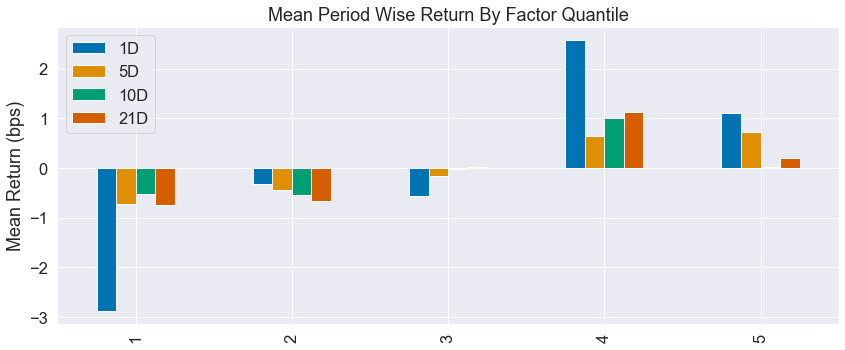

In [13]:
create_summary_tear_sheet(lr_factor_data);

## 岭回归

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001953
                           AAPL     -0.001374
                           ABBV      0.001091
                           AGN       0.001934
                           AIG      -0.000471
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036597,0.009164,-0.003368,0.003631,14982,20.231183
2,-0.012857,0.011247,-0.001338,0.003060,14877,20.089394
3,-0.010657,0.012705,-0.000268,0.003092,14336,19.358846
4,-0.009426,0.015165,0.000752,0.003225,14877,20.089394
5,-0.007759,0.038524,0.002717,0.004053,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.023,0.014,0.011
beta,-0.007,-0.081,-0.061,0.015
Mean Period Wise Return Top Quantile (bps),1.377,0.549,0.071,0.210
Mean Period Wise Return Bottom Quantile (bps),-2.776,-1.345,-1.045,-1.153
Mean Period Wise Spread (bps),4.153,1.920,1.136,1.353


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.013,0.014
IC Std.,0.181,0.169,0.169,0.155
Risk-Adjusted IC,0.110,0.083,0.080,0.090
t-stat(IC),3.011,2.278,2.182,2.452
p-value(IC),0.003,0.023,0.029,0.014
IC Skew,0.004,-0.016,-0.042,-0.029
IC Kurtosis,-0.143,-0.192,-0.146,-0.279


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.293,0.512,0.617,0.725
Quantile 2 Mean Turnover,0.508,0.703,0.753,0.789
Quantile 3 Mean Turnover,0.562,0.729,0.776,0.806
Quantile 4 Mean Turnover,0.504,0.694,0.749,0.786
Quantile 5 Mean Turnover,0.297,0.521,0.633,0.737


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.824,0.565,0.407,0.252


<Figure size 432x288 with 0 Axes>

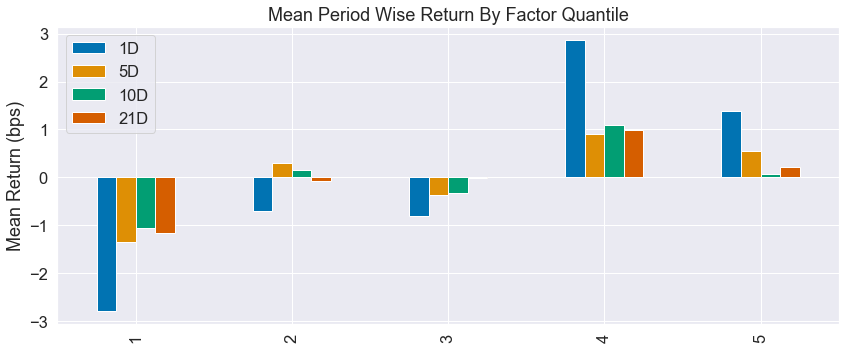

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso回归

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001872
                           AAPL     -0.001646
                           ABBV      0.001163
                           AGN       0.001919
                           AIG      -0.000530
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.044839,0.009398,-0.003459,0.003828,14982,20.231183
2,-0.014281,0.011321,-0.001359,0.003232,14877,20.089394
3,-0.012327,0.013100,-0.000258,0.003285,14336,19.358846
4,-0.010948,0.015352,0.000791,0.003434,14877,20.089394
5,-0.009000,0.038298,0.002835,0.004327,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.034,0.022,0.012,0.009
beta,-0.009,-0.078,-0.058,0.014
Mean Period Wise Return Top Quantile (bps),1.967,0.778,0.044,0.238
Mean Period Wise Return Bottom Quantile (bps),-2.507,-0.772,-0.764,-0.906
Mean Period Wise Spread (bps),4.473,1.579,0.827,1.134


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.013,0.014
IC Std.,0.181,0.168,0.168,0.155
Risk-Adjusted IC,0.111,0.082,0.075,0.093
t-stat(IC),3.037,2.239,2.058,2.551
p-value(IC),0.002,0.025,0.040,0.011
IC Skew,0.002,-0.011,-0.035,-0.022
IC Kurtosis,-0.152,-0.192,-0.161,-0.307


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.296,0.517,0.619,0.728
Quantile 2 Mean Turnover,0.513,0.705,0.752,0.789
Quantile 3 Mean Turnover,0.566,0.737,0.778,0.806
Quantile 4 Mean Turnover,0.504,0.698,0.752,0.783
Quantile 5 Mean Turnover,0.297,0.527,0.636,0.739


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.553,0.397,0.243


<Figure size 432x288 with 0 Axes>

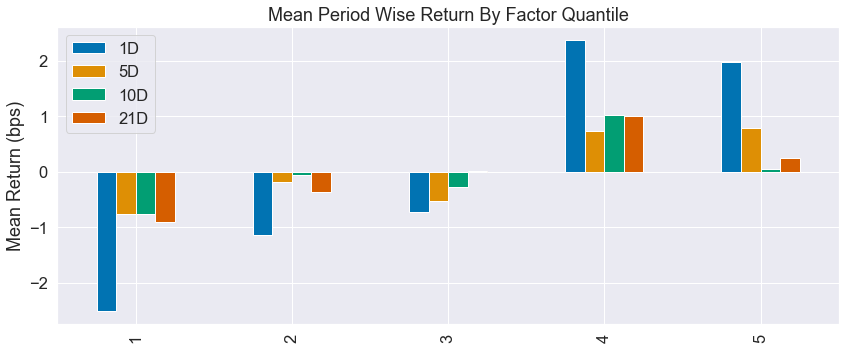

In [21]:
create_summary_tear_sheet(lasso_factor_data);